# Гипотезы для увеличения выручки

Задачи исследования: приоритизация гипотез об оптимизации выручки интернет-магазина для проведения A/B теста по наиболее приоритетной гипотезе и последующий анализ его результатов. Исследование должно ответить на вопрос, стоит ли продолжать тест или принять положительный либо отрицательный его результат.

План:

* [Часть 1.Часть 1. Приоритизация гипотез](#chapter1)
   * [0. Выгрузка данных для первой части](#section1_1)
   * [1. ICE](#section1_2)
   * [2.RICE](#section1_3)
   * [3. Сравнение ICE и RICE. Выводы по первой части](#section1_4)

* [Часть 2. Анализ результатов A/B теста](#chapter2)
    * [0. Выгрузка данных для второй части](#section2_1)
    * [1. Кумулятивные данные](#section2_2)
    * [2. Графики дохода, конверсий среднего чека](#section2_3)
    * [3. Точечные гафики и перцентили - вычисление аномалий](#section2_4)
    * [4. Вычисление статистической значимости различий для сырых данных](#section2_5)
    * [5. Вычисление статистической значимости различий для очищенных данных](#section2_6)
    * [6. Принятие решения](#section2_7)

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 400)
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from scipy import stats as st
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Часть 1. Приоритизация гипотез <a class="anchor" id="chapter1"></a>

### Выгрузка данных <a class="anchor" id="section1_1"></a>

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
# Приведем названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
print(hypothesis.dtypes)

hypothesis    object
reach          int64
impact         int64
confidence     int64
efforts        int64
dtype: object


Данные в порядке: нет пропусков, дубликатов, артефактов итп. Типы данных везде правильные.

### ICE <a class="anchor" id="section1_2"></a>

In [4]:
# Добавим столбец 'ice' в таблицу hypothesis
hypothesis['ice'] = ((hypothesis.impact * hypothesis.confidence) / hypothesis.efforts).round(2)
# Отсортируем значения по столбцу 'ice'
sorted_by_ice = hypothesis.sort_values(by = 'ice', ascending = False).reset_index(drop=True)
display(sorted_by_ice)

,hypothesis,reach,impact,confidence,efforts,ice
0,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Получили список гипотез в порядке приоритетности по критерию ICE

### RICE <a class="anchor" id="section1_3"></a>

In [5]:
# Добавим столбец 'rice' в отсортированную таблицу
sorted_by_ice['rice'] = ((sorted_by_ice.reach * sorted_by_ice.impact * sorted_by_ice.confidence) / sorted_by_ice.efforts).round(2)
# Отсортируем по столбцу 'rice' и сохраним в столбце 'index' индексацию из таблицы,
# отсортированной по 'ice' для удобства сравнения приоритетности RICE и ICE
sorted_by_rice = sorted_by_ice.sort_values(by = 'rice', ascending = False).reset_index()
display(sorted_by_rice)

,index,hypothesis,reach,impact,confidence,efforts,ice,rice
0,2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
1,4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
2,1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
3,3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
4,0,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
5,7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
6,5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
7,6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
8,8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Получили список гипотез в порядке приоритетности по критерию RICE

### Сравнение ICE и RICE. Выводы по первой части. <a class="anchor" id="section1_4"></a>

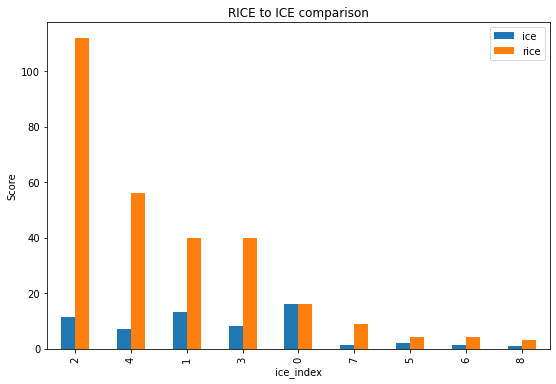

In [6]:
sorted_by_rice = sorted_by_rice.rename(columns = {'index': 'ice_index'})
sorted_by_rice.plot(kind = 'bar', x = 'ice_index', y = ['ice', 'rice'], figsize = (9, 6))
plt.ylabel("Score")
plt.title("RICE to ICE comparison")
plt.show()

Приоритетность гипотез по критериям ICE и RICE различна, что не удивительно, ведь RICE учитывает на один фактор больше. После учета охвата пользователей гипотеза, которая была на третьем месте (индекс 2) по ICE переместилась на первое. Ее охват - максимальный, 10 баллов из 10 возможных. Та гипотеза, которая была самой приоритетной по ICE, напротив, имеет минимальный охват - 1 балл, в результате она опустилась на пятое место в списке приоритетности по RICE.

## Часть 2. Анализ результатов A/B теста <a class="anchor" id="chapter2"></a>

### Выгрузка данных <a class="anchor" id="section2_1"></a>

In [7]:
visitors = pd.read_csv('visitors.csv')
orders = pd.read_csv('orders.csv')
display(visitors.head())
display(visitors.info())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [8]:
# Приведем дату в visitors к соответствующему типу
visitors.date = pd.to_datetime(visitors.date)
print(visitors.dtypes)

date        datetime64[ns]
group               object
visitors             int64
dtype: object


In [9]:
# Сделаем в orders имена столбцов с нижним подчеркиванием в качестве словораздела
orders = orders.rename(columns = {'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
display(orders.head())
print(orders.info())

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


In [10]:
# Приведем дату в  orders к соответствующему типу
orders.date = pd.to_datetime(orders.date)
print(orders.dtypes)

transaction_id             int64
visitor_id                 int64
date              datetime64[ns]
revenue                    int64
group                     object
dtype: object


In [11]:
visitors_a = orders[orders.group == 'A'].visitor_id.unique()
visitors_b = orders[orders.group == 'B'].visitor_id.unique()

both_groups_visitors = []

for i in visitors_a:
    if i in visitors_b:
        both_groups_visitors.append(i)
        
print(len(both_groups_visitors))

#orders = orders.query('visitor_id not in @both_groups_visitors')

58


Данные в порядке: нет пропусков, дубликатов, артефактов итп. Типы данных везде правильные.

In [12]:
display(orders.head())
display(visitors.head())

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Анализ результатов A/B теста

### Кумулятивные данные <a class="anchor" id="section2_2"></a>

Для построения необходимых графиков сначала создадим таблицу с кумулятивными метриками для групп A и B: кумулятивным средним чеком, кумулятивным доходом, кумулятивной конверсией.

In [13]:
# Почитаем, сколько всего на каждую группу каждый день приходилось дохода, транзакций и уникальных покупателей 
revenues_transactions_buyers = orders.groupby(['date', 'group'], as_index = False).agg({'revenue' : 'sum', 'transaction_id': 'count'}).sort_values(by = ['date', 'group']).reset_index(drop=True)
revenues_transactions_buyers = revenues_transactions_buyers.rename(columns = {'transaction_id': 'transactions'})
display(revenues_transactions_buyers.head())

,date,group,revenue,transactions
0,2019-08-01,A,148579,24
1,2019-08-01,B,101217,21
2,2019-08-02,A,93822,20
3,2019-08-02,B,165531,24
4,2019-08-03,A,112473,24


In [14]:
# Отсортируем таблицу посетителей по дате и группе и объединим ее с получившейся таблицей
# дохода и транзакций

visitors = visitors.sort_values(by = ['date', 'group']).reset_index(drop=True)
all_data = pd.merge(revenues_transactions_buyers, visitors, on = ['date', 'group'])
display(all_data.head())

,date,group,revenue,transactions,visitors
0,2019-08-01,A,148579,24,719
1,2019-08-01,B,101217,21,713
2,2019-08-02,A,93822,20,619
3,2019-08-02,B,165531,24,581
4,2019-08-03,A,112473,24,507


In [15]:
# Сделаем срезы по группам A и B, чтобы вычислять для каждой кумулятивные метрики
group_a_data = all_data.query('group == "A"').reset_index(drop=True)
group_b_data = all_data.query('group == "B"').reset_index(drop =True)

In [16]:
# Вычислим кумулятивные метрики для группы A 
# Кумулятивный доход
group_a_data['cum_rev'] = group_a_data.revenue.cumsum()
# Кумулятивный средний чек = кумулятивный доход / кумулятивное число транзакций
group_a_data['cum_avg_check'] = (group_a_data.cum_rev / group_a_data.transactions.cumsum()).round(2)
# Кумулятивная конверсия = кумулятивное число транзакций /  кумулятивное число посетителей
group_a_data['cum_conversion_percent'] = (group_a_data.transactions.cumsum() / group_a_data.visitors.cumsum() * 100).round(2)
display(group_a_data.head())

,date,group,revenue,transactions,visitors,cum_rev,cum_avg_check,cum_conversion_percent
0,2019-08-01,A,148579,24,719,148579,6190.79,3.34
1,2019-08-02,A,93822,20,619,242401,5509.11,3.29
2,2019-08-03,A,112473,24,507,354874,5218.74,3.69
3,2019-08-04,A,70825,16,717,425699,5067.85,3.28
4,2019-08-05,A,124218,25,756,549917,5045.11,3.29


In [17]:
# Все то же самое для группы B

group_b_data['cum_rev'] = group_b_data.revenue.cumsum()
group_b_data['cum_avg_check'] = (group_b_data.cum_rev / group_b_data.transactions.cumsum()).round(2)
group_b_data['cum_conversion_percent'] = (group_b_data.transactions.cumsum() / group_b_data.visitors.cumsum() * 100).round(2)
display(group_b_data.head())

,date,group,revenue,transactions,visitors,cum_rev,cum_avg_check,cum_conversion_percent
0,2019-08-01,B,101217,21,713,101217,4819.86,2.95
1,2019-08-02,B,165531,24,581,266748,5927.73,3.48
2,2019-08-03,B,114248,16,509,380996,6245.84,3.38
3,2019-08-04,B,108571,17,770,489567,6276.50,3.03
4,2019-08-05,B,92428,23,707,581995,5762.33,3.08


In [18]:
# Возьмем из обеих таблиц столбцы с датой и с кумулятивными метриками и объединим их в единую
# таблицу кумулятивных данных. Получится таблица с семью столбцами: дата + (3 метрики * 2 группы)

cum_data_a = group_a_data[['date', 'cum_rev', 'cum_avg_check', 'cum_conversion_percent']]
cum_data_a = cum_data_a.rename(columns ={'cum_rev': 'cum_rev_a', 'cum_avg_check': 'cum_avg_check_a', 'cum_conversion_percent': 'cum_conversion_percent_a'})

cum_data_b = group_b_data[['date', 'cum_rev', 'cum_avg_check', 'cum_conversion_percent']]
cum_data_b = cum_data_b.rename(columns ={'cum_rev': 'cum_rev_b', 'cum_avg_check': 'cum_avg_check_b', 'cum_conversion_percent': 'cum_conversion_percent_b'})

cum_data = pd.merge(cum_data_a, cum_data_b, on = 'date')

display(cum_data.head())


,date,cum_rev_a,cum_avg_check_a,cum_conversion_percent_a,cum_rev_b,cum_avg_check_b,cum_conversion_percent_b
0,2019-08-01,148579,6190.79,3.34,101217,4819.86,2.95
1,2019-08-02,242401,5509.11,3.29,266748,5927.73,3.48
2,2019-08-03,354874,5218.74,3.69,380996,6245.84,3.38
3,2019-08-04,425699,5067.85,3.28,489567,6276.50,3.03
4,2019-08-05,549917,5045.11,3.29,581995,5762.33,3.08


Теперь у нас есть таблица, пользуясь которой можно построить несколько графиков по кумулятивным метрикам.

### График кумулятивного дохода групп A и B <a class="anchor" id="section2_3"></a>

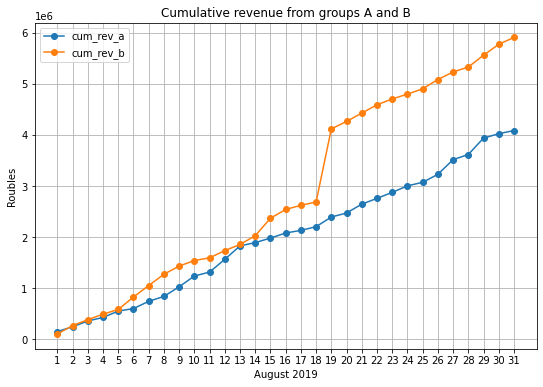

In [19]:
ax = cum_data.plot(y = ['cum_rev_a', 'cum_rev_b'], style = 'o-', grid=True, figsize = (9, 6))
ax.set_xticks([i for i in range(31)])
ax.set_xticklabels([i for i in range(1, 32)])
ax.set_xlabel('August 2019')
ax.set_ylabel('Roubles')
plt.title('Cumulative revenue from groups A and B')
plt.show()

Кумулятивный доход от группы B с середины месяца начинает заметно превышать доход от группы А. Это может объясняться как тем, что группа B действительно будет приносить больше дохода, так и случайностью: например, на графике виден резкий скачок группы B 19 августа, который может быть просто аномалией.

### График кумулятивного среднего чека для групп A и B

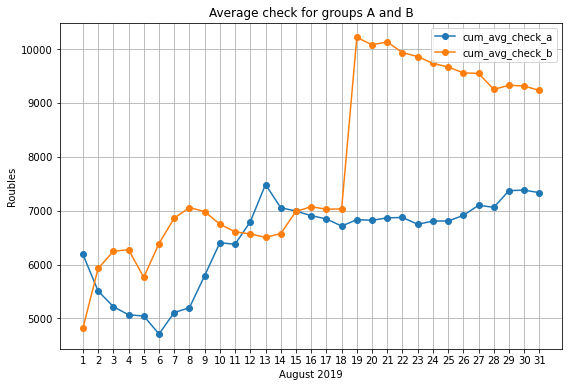

In [20]:
ax = cum_data.plot(y = ['cum_avg_check_a', 'cum_avg_check_b'], style = 'o-', grid = True, figsize = (9, 6))
ax.set_xticks([i for i in range(31)])
ax.set_xticklabels([i for i in range(1, 32)])
ax.set_xlabel('August 2019')
ax.set_ylabel('Roubles')
plt.title("Average check for groups A and B")
plt.show()

Скачок группы B 19 августа еще более выражен на графике среднего чека. Наверное, влияние выбросов. До 19 августа никакой тенденции, после - тенденция к сближению групп A и B (т.е. возможно, то, что видно на графике после 19 августа, - это постепенная коррекция кумулятивного среднего чека группы B после всплеска).

### График относительного изменения среднего чека группы B к группе А

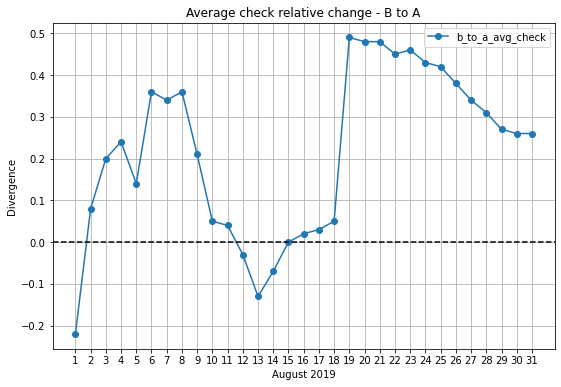

In [21]:
# Найдем относительное изменение средних чеков
cum_data['b_to_a_avg_check'] = (cum_data.cum_avg_check_b / cum_data.cum_avg_check_a - 1).round(2)
# График
ax = cum_data.plot (y = 'b_to_a_avg_check', style = 'o-', grid = True, figsize = (9,6))
ax.set_xticks([i for i in range(31)])
ax.set_xticklabels([i for i in range(1, 32)])
ax.set_xlabel('August 2019')
ax.set_ylabel('Divergence')
plt.title("Average check relative change - B to A")
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.show()

Снова можно сказать, что если бы не экстраординарный день 19 августа, то в целом график относительного изменения среднего чека колебался бы около ноля.

### График кумулятивной конверсии групп A и B

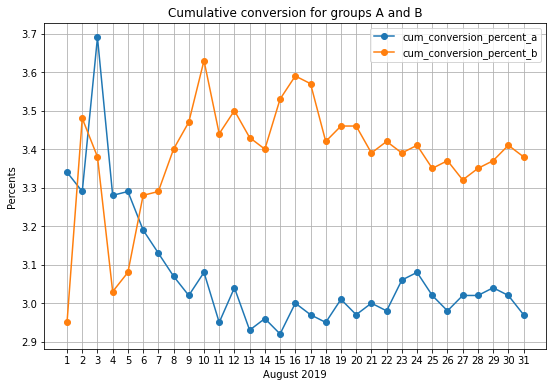

In [22]:
ax = cum_data.plot(y = ['cum_conversion_percent_a', 'cum_conversion_percent_b'], style = 'o-', grid = True, figsize = (9,6))
ax.set_xticks([i for i in range(31)])
ax.set_xticklabels([i for i in range(1, 32)])
ax.set_xlabel('August 2019')
ax.set_ylabel('Percents')
plt.title("Cumulative conversion for groups A and B")
plt.show()

Кумулятивная конверсия групп после первой недели августа различна. У группы B - конверсия больше, график колеблется между отметками 3.4% и 3.6%, у группы A - между 2.9 и 3.1%. Таким образом, конверсия группы B в среднем примерно на 1/6 (около 16%) выше, чем у группы А. То, что было на первой неделе, возможно, объясняется влияннием выбросов. Впрочем, для окончательных выводов еще рановато.

### График относительного изменения конверсии группы B к группе A

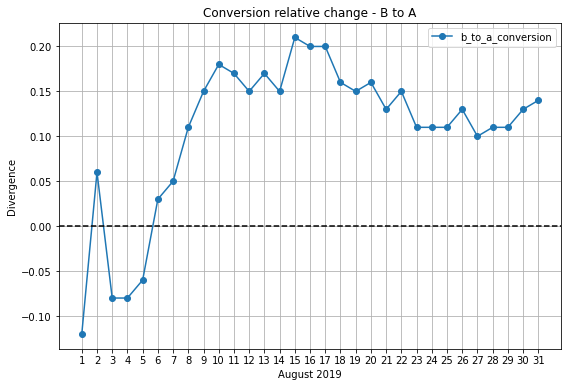

In [23]:
# Найдем относительное изменение конверсии
cum_data['b_to_a_conversion'] = (cum_data.cum_conversion_percent_b / cum_data.cum_conversion_percent_a - 1).round(2)
# График
ax = cum_data.plot (y = 'b_to_a_conversion', style = 'o-', grid = True, figsize = (9,6))
ax.set_xticks([i for i in range(31)])
ax.set_xticklabels([i for i in range(1, 32)])
ax.set_xlabel('August 2019')
ax.set_ylabel('Divergence')
plt.title("Conversion relative change - B to A")
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.show()

График относительного изменения конверсии со второй недели колеблется между отметками 0.10 и 0.20. Для выводов пока рано.

### Точечный график количества заказов по пользователям <a class="anchor" id="section2_4"></a>

In [24]:
# Сгруппируем таблицу заказов по пользователям и посчитаем количество заказов
orders_by_visitors = orders.groupby(['visitor_id', 'group'], as_index = False).agg({'transaction_id': 'count'})
orders_by_visitors = orders_by_visitors.rename(columns = {'transaction_id': 'orders'})

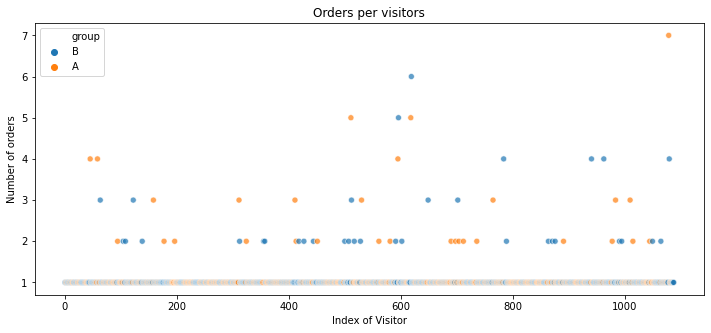

In [25]:
# Построим точечный график заказов по пользователям
plt.figure(figsize = (12, 5))
sns.scatterplot(x= orders_by_visitors.index, y = orders_by_visitors['orders'], hue = orders_by_visitors.group, alpha = 0.7)
plt.ylabel('Number of orders')
plt.xlabel("Index of Visitor")
plt.title("Orders per visitors")
plt.show()

Точечный график показывает, что в основном на одного покупателя приходится один заказ, иногда два, редко - три. Начиная с четырех - единичные случаи. Это, очевидно, и есть аномальные значения.

### 95-й и 99-й перцентили количества заказов по пользователям

In [26]:
print(np.percentile(orders_by_visitors.orders, 95))
print(np.percentile(orders_by_visitors.orders, 99))

2.0
4.0


99-й перцентиль можно считать "водоразделом" между аномальными и нормальными значениями: обычный покупатель совершает не более трех покупок.

### Точечный график стоимости заказов

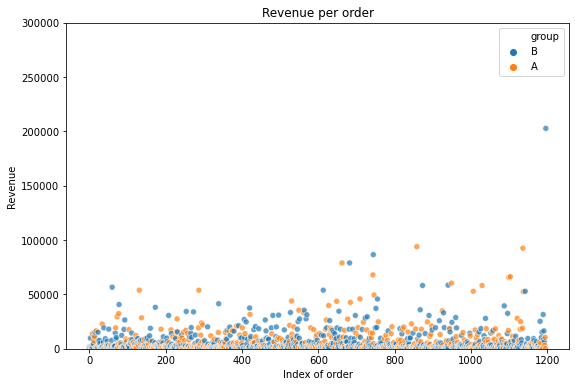

In [27]:
plt.figure(figsize =(9,6))
sns.scatterplot(x = orders.index, y = orders.revenue, hue = orders.group, alpha =0.7)
plt.ylabel('Revenue')
plt.ylim(0, 300000)
plt.xlabel('Index of order')
plt.title("Revenue per order")
plt.show()

Точечный график показывает, что стоимость основной массы заказов не превышает нескольких десятков тысяч рублей. Точнее будет видно по перцентилям.

### 95-й и 99-й перцентили стоимости заказов

In [28]:
print(np.percentile(orders.revenue, 95))
print(np.percentile(orders.revenue, 99))

28000.000000000004
58233.19999999999


Используя 99-й перцентиль, будем считать, что все заказы дороже 58 000 руб - аномальны

### Выборки для тестирования статистической значимости различия конверсий (сырые данные) <a class="anchor" id="section2_5"></a>

In [29]:
# Создадим срезы по группам из таблицы заказов по пользователям
orders_by_visitors_a = orders_by_visitors.query('group == "A"')
orders_by_visitors_b = orders_by_visitors.query('group == "B"')

# Разделим таблицу посетителей по группам A и B
visitors_a = visitors.query('group == "A"')
visitors_b = visitors.query('group == "B"')

# Вычислим для обеих групп количество посетителей, не совершавших покупок,
# как разницу между суммой посетителей и длиной таблицы количества заказов по посетителям

a_nulls = visitors_a.visitors.sum() - len(orders_by_visitors_a)
b_nulls = visitors_b.visitors.sum() - len(orders_by_visitors_b)

# Создадим таблицы нулевых заказов: число строк равно количеству посетителей, не совершавших покупок,
# значения - нули
a_nulls_table = pd.Series(0, index = np.arange(a_nulls), name = 'orders')
b_nulls_table = pd.Series(0, index = np.arange(b_nulls), name = 'orders')

In [30]:
# Соединим таблицы с числом заказов на посетителя с таблицами нулевых заказов
sample_a  = pd.concat([orders_by_visitors_a.orders, a_nulls_table], axis=0)
sample_b  = pd.concat([orders_by_visitors_b.orders, b_nulls_table], axis=0)

### Статистическая значимость различия конверсий по сырым данным

Нулевая гипотеза: значимого различия конверсий групп A и B нет. Видимые различия - случайны, в действительности конверсии не отличаются.

Альтернативная гипотеза: зафиксированные различия конверсий не случайны, они имеют высокую статистическую значимость, следует считать, что они действительно различны.

Уровень статистической значимости (alpha): 0.05

In [31]:
# Тест Манна-Уитни
results = st.mannwhitneyu(sample_a, sample_b)
# P-значение
print(results.pvalue)
# Сравнение p-значения с порогом статистической значимости 0.05
print(results.pvalue < 0.05)

0.008396177528376304
True


По сырым данным кажется, что статистическая значимость различия конверсий достаточно велика: нулевую гипотезу можно отвергнуть, признав что у групп A и B конверсии различны.

### Статистическая значимость различия средних чеков по сырым данным

Нулевая гипотеза: различия между средними чеками случайны, статистически значимой разницы между средними чеками групп A и B - нет.

Альтернативная гипотеза: средние чеки групп A и B действительно различаются.

Уровень статистической значимости (alpha): 0.05

In [32]:
results = st.mannwhitneyu(orders[orders.group == "A"]['revenue'], orders[orders.group == 'B']['revenue'])
print(results.pvalue)
print(results.pvalue < 0.05)

0.3646454927716229
False


Нулевую гипотезу отвергнуть не получается, есть заметная вероятность того, что разница между средними чеками, случайна.

### Очищенные данные <a class="anchor" id="section2_6"></a>

In [33]:
# Создадим список уникальных пользователей таблицы orders, применив фильтр по выручке
revenues_abnormal = orders.query('revenue >= 58000').visitor_id.unique()

# Используем этот список и второй фильтр (по количеству заказов) -
# и отфильтруем таблицу orders_by_visitors
orders_by_visitors_filtered = orders_by_visitors.query('visitor_id not in @revenues_abnormal and orders < 4')
print(orders_by_visitors_filtered.orders.max())
# Разобьем получившуюся таблицу по группам
orders_by_visitors_a_filtered = orders_by_visitors_filtered.query('group == "A"')
orders_by_visitors_b_filtered = orders_by_visitors_filtered.query('group == "B"')

3


In [34]:
# Создадим выборки из отфильтрованных таблиц количества заказов на каждого посетителя
# и таблиц с нулевыми заказами для тестирования значимости различия конверсий
sample_a_filtered = pd.concat([orders_by_visitors_a_filtered.orders, a_nulls_table], axis = 0)
sample_b_filtered = pd.concat([orders_by_visitors_b_filtered.orders, b_nulls_table], axis = 0)

# Применим фильтры к таблице orders, чтобы при тестировании различий среднего чека
# использовать ее столбец revenue
visitors_normal = orders_by_visitors_filtered.visitor_id.unique()
orders_filtered = orders.query('visitor_id in @visitors_normal')
print(orders_filtered.revenue.max())

53904


### Статистическая значимость различия конверсий по очищенным данным

Нулевая гипотеза: значимого различия конверсий групп A и B нет. Видимые различия - случайны, в действительности конверсии не отличаются.

Альтернативная гипотеза: зафиксированные различия конверсий не случайны, они имеют высокую статистическую значимость, следует считать, что они действительно различны.

Уровень статистической значимости (alpha): 0.05

In [35]:
results = st.mannwhitneyu(sample_a_filtered, sample_b_filtered)
print(results.pvalue)
print(results.pvalue < 0.05)

0.0070847250884960395
True


Статистическая значимость различия конверсий по-прежнему высока. Нулевую гипотезу можно отвергнуть: конверсии групп A и B различны.

### Статистическая значимость различия среднго чека по очищенным данным

Нулевая гипотеза: различия между средними чеками случайны, статистически значимой разницы между средними чеками групп A и B - нет.

Альтернативная гипотеза: средние чеки групп A и B действительно различаются.

Уровень статистической значимости (alpha): 0.05

In [36]:
results = st.mannwhitneyu(orders_filtered[orders_filtered.group == "A"].revenue, orders_filtered[orders_filtered.group == 'B'].revenue)
print(results.pvalue)
print(results.pvalue < 0.05)

0.39230210710689517
False


Вероятность того, что различия между средними чеками двух групп - случайность - 39%. В принципе, этого стоило ожидать, глядя на графики, где 19 августа резкий скачок. После устранения аномалий стало понятно, что нулевую гипотезу отвергнуть нельзя. Чтобы сделать выводы по эксперименту, нужно посчитать, сколько времени он должен идти. Конверсии сильно поменялись при очистке данных, это, возможно, свидетельствует о том, что тест идет слишком недолго для выводов.

### Принятие решения <a class="anchor" id="section2_7"></a>

Используем калькулятор расчета длительности теста на странице: https://vwo.com/tools/ab-test-duration-calculator/ .

In [37]:
# Для того чтобы воспользоваться калькулятором посчитаем среднедневное число посетителей сайта
# базовый уровень конверсии

# Среднедневное число посетителей сайта
print(int(group_a_data.visitors.mean() + group_b_data.visitors.mean()))
# В качестве оценки базового уровеня конверсии возьмем среднюю конверсию группы A за август 2019
# (она равна кумулятивной конверсии группы A на 31 августа)
print(float(cum_data[cum_data.date == '2019-08-31'].cum_conversion_percent_a))

1214
2.97


При базовой конверсии 2.97%, 1214 посетителях каждый день, 100% из которых участвуют в тесте, и если задать минимальное изменение уровня конверсии, которое мы хотим обнаружить, как 10%, то длительность теста должна составить 86 дней. На данный момент (31 августа 2019 года) тест длится 31 день.

Вывод: следует продолжить проведение теста в сентябре и октябре 2019 года.